In [ ]:
import os
import pickle
from collections import Counter
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [268]:
# Chemins vers les fichiers de données d'entraînement et de test
DATA_PATH = "ift-3395-6390-kaggle-2-competition-fall-2025/train_data.pkl"
TEST_PATH = "ift-3395-6390-kaggle-2-competition-fall-2025/test_data.pkl"

# Chemin vers le fichier où le meilleur modèle sera sauvegardé
MODEL_PATH = "best_model_1.pth"

# Hyperparamètres globaux
BATCH_SIZE = 64      # Taille des mini-lots
NUM_CLASSES = 5      # Nombre de classes (0 à 4)
NUM_EPOCHS = 20      # Nombre d'époques d'entraînement
VAL_SIZE = 0.15      # Proportion des données utilisées pour la validation
SEED = 42            # SEED aléatoire pour la reproductibilité

# Hyperparamètres d'optimisation
LR = 5e-4            # Learning rate
WEIGHT_DECAY = 3e-4  # Terme de régularisation L2 


DEVICE = torch.device(
    "mps" if torch.backends.mps.is_available() else
    ("cuda" if torch.cuda.is_available() else "cpu")
)

def set_seed(seed=42):
    # Fixe les SEEDS aléatoires pour assurer la reproductibilité
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

# Initialisation des SEEDS aléatoires
set_seed(SEED)


In [269]:
def load_data_pkl(path):
    # Chargement des données depuis un fichier pickle
    with open(path, "rb") as f:
        data = pickle.load(f)

    # Extraction des images
    images = data["images"].astype(np.uint8)

    # Extraction des labels et conversion en tableau 
    labels = np.asarray(data["labels"], dtype=np.int64).reshape(-1)

    return images, labels


# Chargement des données d'entraînement
images, labels = load_data_pkl(DATA_PATH)

# Vérification de la dimension des images (28x28 RGB)
assert images.shape[1:] == (28, 28, 3), "Les images doivent être en 28x28x3."

# Affichage des dimensions pour validation
print("\nImages:", images.shape)
print("Labels:", labels.shape)




Images: (1080, 28, 28, 3)
Labels: (1080,)


In [270]:
class RetinaDataset(Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.images = images
        self.labels = labels  
        self.transform = transform

    def __len__(self):
        # Retourne le nombre total d'images dans le dataset
        return len(self.images)

    def __getitem__(self, idx):
        # Conversion de l'image NumPy en image PIL
        img = Image.fromarray(self.images[idx])

        # Application des transformations 
        if self.transform:
            img = self.transform(img)

        # Retourne l'image et son label 
        if self.labels is not None:
            return img, int(self.labels[idx])
        else:
            # Cas de l'ensemble de test (sans labels)
            return img



In [271]:
# Définition des transformations d'augmentation de données
augment = transforms.Compose([
    # Ajustement aléatoire du contraste
    transforms.RandomAutocontrast(p=0.3),

    # Application d'un flou gaussien léger
    transforms.GaussianBlur(3, 0.3),

    # Rotation aléatoire 
    transforms.RandomRotation(degrees=3),

    # Flip horizontal aléatoire
    transforms.RandomHorizontalFlip(p=0.5),

    # Flip vertical aléatoire
    transforms.RandomVerticalFlip(p=0.5),

    # Cisaillement
    transforms.RandomAffine(degrees=0, shear=5),
])


In [272]:
def preprocess_retina(img_tensor):
    # Séparation des canaux de couleur (R, G, B)
    R = img_tensor[0]
    G = img_tensor[1]
    B = img_tensor[2]

    def normalize_channel(c):
        # Normalisation min-max d'un canal
        return (c - c.min()) / (c.max() - c.min() + 1e-6)

    # Normalisation indépendante de chaque canal
    Rn = normalize_channel(R)
    Gn = normalize_channel(G)
    Bn = normalize_channel(B)

    # Calcul de l'amplitude du canal vert
    g_range = G.max() - G.min()

    # Renforcement du contraste si le canal vert est peu contrasté
    if g_range < 0.15:
        gain = 0.3 / (g_range + 1e-6)
        Gn = torch.clamp(Gn * gain, 0, 1)

    # Reconstruction de l'image normalisée
    return torch.stack([Rn, Gn, Bn], dim=0)



In [273]:
# Transformations appliquées aux images de l'ensemble d'entraînement
train_transform = transforms.Compose([
    # Conversion de l'image PIL en tenseur PyTorch
    transforms.ToTensor(),

    # Prétraitement des images 
    transforms.Lambda(preprocess_retina),

    # Normalisation des canaux 
    transforms.Normalize(mean=[0.5] * 3, std=[0.25] * 3),
])

# Transformations appliquées aux images de l'ensemble de validation
val_transform = transforms.Compose([
    # Conversion de l'image PIL en tenseur PyTorch
    transforms.ToTensor(),

    # Prétraitement aux images 
    transforms.Lambda(preprocess_retina),

    # Normalisation identique à celle de l'entraînement
    transforms.Normalize(mean=[0.5] * 3, std=[0.25] * 3),
])


In [274]:
# Séparation des indices des données en ensembles d'entraînement et de validation
train_idx, val_idx = train_test_split(
    np.arange(len(images)), 
    test_size=VAL_SIZE,     
    random_state=SEED,       
    shuffle=True,            
    stratify=labels         
)

# Extraction des images et labels correspondants aux indices d'entraînement
train_images, train_labels = images[train_idx], labels[train_idx]

# Extraction des images et labels correspondants aux indices de validation
val_images, val_labels = images[val_idx], labels[val_idx]


In [275]:
def oversample_class(images, labels, target_class, factor):
    # Récupération des indices des images appartenant à la classe cible
    idxs = np.where(labels == target_class)[0]

    # Listes pour stocker les nouvelles images et leurs labels
    new_imgs, new_lbls = [], []

    # Boucle sur les images de la classe cible
    for idx in idxs:
        img = images[idx]

        # Génération d'images augmentées pour sur-échantillonner la classe
        for _ in range(factor - 1):
            aug_img = np.array(augment(Image.fromarray(img)))
            new_imgs.append(aug_img)
            new_lbls.append(target_class)

    return new_imgs, new_lbls


# Facteurs de sur-échantillonnage par classe
oversample_factor = {0: 1, 1: 4, 2: 2, 3: 2, 4: 6}

# Listes pour stocker toutes les nouvelles images générées
all_new_imgs, all_new_lbls = [], []

# Application du sur-échantillonnage pour chaque classe
for cls, factor in oversample_factor.items():
    if factor > 1:
        imgs_new, lbls_new = oversample_class(
            train_images, train_labels, cls, factor
        )
        all_new_imgs += imgs_new
        all_new_lbls += lbls_new

# Ajout des images augmentées à l'ensemble d'entraînement
if all_new_imgs:
    all_new_imgs = np.stack(all_new_imgs)
    all_new_lbls = np.array(all_new_lbls)

    train_images = np.concatenate([train_images, all_new_imgs])
    train_labels = np.concatenate([train_labels, all_new_lbls])

# Affichage de la nouvelle distribution des classes
print("Train distribution:", Counter(train_labels))


Train distribution: Counter({np.int64(1): 436, np.int64(0): 413, np.int64(2): 350, np.int64(4): 336, np.int64(3): 330})


In [276]:
# Création du dataset pour l'ensemble d'entraînement
train_dataset = RetinaDataset(
    train_images,
    train_labels,
    train_transform
)

# Création du dataset pour l'ensemble de validation
val_dataset = RetinaDataset(
    val_images,
    val_labels,
    val_transform
)

# DataLoader pour l'entraînement 
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# DataLoader pour la validation 
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)


In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()

        # Bloc d'extraction de caractéristiques convolutionnelles
        self.features = nn.Sequential(
            # Première couche convolutionnelle
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Deuxième couche convolutionnelle
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Troisième couche convolutionnelle
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Pooling global adaptatif pour réduire la dimension spatiale
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # Classifieur final
        self.classifier = nn.Sequential(
            nn.Dropout(0.25),             # Régularisation par dropout
            nn.Linear(128, num_classes)   # Couche fully-connected
        )

    def forward(self, x):
        # Passage dans les couches convolutionnelles
        x = self.features(x)

        # Réduction spatiale par global average pooling
        x = self.gap(x)

        # Mise à plat des caractéristiques
        x = x.view(x.size(0), -1)

        # Prédiction des scores de classes
        return self.classifier(x)


# Initialisation du modèle 
model = CNN().to(DEVICE)


In [ ]:
# Calcul de la distribution des classes dans l'ensemble d'entraînement
counter = Counter(train_labels.tolist())

weights = torch.tensor(
    [1.0 / (counter[c] ** 0.5) for c in range(NUM_CLASSES)],
    dtype=torch.float32
)

weights /= weights.sum()

# Définition de la fonction de perte 
criterion = nn.CrossEntropyLoss(weight=weights.to(DEVICE))

# Initialisation de l'optimiseur Adam avec régularisation L2
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)


In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device):

    model.train()

    running_loss = 0.0

    # Listes pour stocker toutes les prédictions et les cibles
    all_preds, all_targets = [], []

    # Boucle sur les mini-lots de l'ensemble d'entraînement
    for imgs, targets in loader:
        imgs, targets = imgs.to(device), targets.to(device)

        # Remise à zéro des gradients
        optimizer.zero_grad()

        # Propagation avant
        outputs = model(imgs)

        # Calcul de la fonction de perte
        loss = criterion(outputs, targets)

        # Rétropropagation
        loss.backward()

        # Mise à jour des paramètres
        optimizer.step()

        # Accumulation de la perte 
        running_loss += loss.item() * imgs.size(0)

        # Prédiction des classes 
        preds = outputs.argmax(dim=1)

        # Sauvegarde des prédictions et des cibles
        all_preds.append(preds.detach().cpu().numpy())
        all_targets.append(targets.detach().cpu().numpy())

    # Concaténation des prédictions et des cibles
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    # Calcul des métriques sur l'ensemble de l'époque
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_score(all_targets, all_preds)
    epoch_recall_macro = recall_score(all_targets, all_preds, average="macro")
    epoch_f1_macro = f1_score(all_targets, all_preds, average="macro")

    return epoch_loss, epoch_acc, epoch_recall_macro, epoch_f1_macro



In [ ]:
def evaluate(model, loader, criterion, device):
    model.eval()

    running_loss = 0.0

    # Listes pour stocker les prédictions et les cibles
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for imgs, targets in loader:
            imgs, targets = imgs.to(device), targets.to(device)

            # Propagation avant
            outputs = model(imgs)

            # Calcul de la fonction de perte
            loss = criterion(outputs, targets)

            # Accumulation de la perte pondérée par la taille du lot
            running_loss += loss.item() * imgs.size(0)

            # Prédiction des classes
            preds = outputs.argmax(dim=1)

            # Sauvegarde des prédictions et des cibles
            all_preds.append(preds.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Concaténation de toutes les prédictions et cibles
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    # Calcul des métriques globales
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_score(all_targets, all_preds)
    epoch_recall_macro = recall_score(all_targets, all_preds, average="macro")
    epoch_f1_macro = f1_score(all_targets, all_preds, average="macro")

    # Calcul du rappel par classe
    class_recalls = recall_score(
        all_targets, all_preds,
        average=None,
        labels=list(range(NUM_CLASSES))
    )

    # Calcul de la matrice de confusion
    cm = confusion_matrix(
        all_targets, all_preds,
        labels=list(range(NUM_CLASSES))
    )

    return {
        "loss": epoch_loss,
        "acc": epoch_acc,
        "recall_macro": epoch_recall_macro,
        "f1_macro": epoch_f1_macro,
        "class_recalls": class_recalls,
        "confusion_matrix": cm,
        "y_true": all_targets,
        "y_pred": all_preds,
    }


In [ ]:
# Réduit le learning rate lorsque la métrique surveillée stagne
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',        # On cherche à maximiser la métrique
    factor=0.5,        # Facteur de réduction du learning rate
    patience=4         # Nombre d'époques sans amélioration tolérées
)

# Variables pour suivre les meilleures performances
best_acc = best_recall = best_f1 = 0.0

# Boucle principale d'entraînement
for epoch in range(1, NUM_EPOCHS + 1):

    # Entraînement sur une époque
    train_loss, train_acc, train_recall, train_f1 = train_one_epoch(
        model,
        train_loader,
        optimizer,
        criterion,
        DEVICE
    )

    # Évaluation sur l'ensemble de validation
    val_metrics = evaluate(model, val_loader, criterion, DEVICE)

    # Récupération des métriques de validation
    val_loss = val_metrics["loss"]
    val_acc = val_metrics["acc"]
    val_recall = val_metrics["recall_macro"]
    val_f1 = val_metrics["f1_macro"]

    # Affichage des résultats de l'époque courante
    print(f"\nEpoch [{epoch}/{NUM_EPOCHS}]")
    print(f"  Train Loss: {train_loss:.4f} | "
          f"Acc: {train_acc:.4f} | "
          f"Recall: {train_recall:.4f} | "
          f"F1: {train_f1:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | "
          f"Acc: {val_acc:.4f} | "
          f"Recall: {val_recall:.4f} | "
          f"F1: {val_f1:.4f}")

    # Sauvegarde du modèle si une métrique s'améliore
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model_1.pth")
        print(f" Nouveau meilleur Accuracy: {best_acc:.4f}")

    if val_recall > best_recall:
        best_recall = val_recall
        torch.save(model.state_dict(), "best_model_1.pth")
        print(f" Nouveau meilleur Recall Macro: {best_recall:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), "best_model_1.pth")
        print(f"  Nouveau meilleur F1 Macro: {best_f1:.4f}")

    # Mise à jour du learning rate en fonction du recall macro
    scheduler.step(val_recall)





Epoch [1/20]
  Train Loss: 1.5152 | Acc: 0.3223 | Recall: 0.3095 | F1: 0.3015
  Val   Loss: 1.3996 | Acc: 0.4321 | Recall: 0.2919 | F1: 0.2546
  → Nouveau meilleur ACC: 0.4321
  → Nouveau meilleur Recall Macro: 0.2919
  → Nouveau meilleur F1 Macro: 0.2546

Epoch [2/20]
  Train Loss: 1.4223 | Acc: 0.3791 | Recall: 0.3635 | F1: 0.3522
  Val   Loss: 1.5572 | Acc: 0.3210 | Recall: 0.3536 | F1: 0.2559
  → Nouveau meilleur Recall Macro: 0.3536
  → Nouveau meilleur F1 Macro: 0.2559

Epoch [3/20]
  Train Loss: 1.3736 | Acc: 0.3946 | Recall: 0.3800 | F1: 0.3711
  Val   Loss: 1.6164 | Acc: 0.3148 | Recall: 0.3562 | F1: 0.2473
  → Nouveau meilleur Recall Macro: 0.3562

Epoch [4/20]
  Train Loss: 1.3596 | Acc: 0.4129 | Recall: 0.4002 | F1: 0.3859
  Val   Loss: 1.3403 | Acc: 0.4691 | Recall: 0.3420 | F1: 0.3401
  → Nouveau meilleur ACC: 0.4691
  → Nouveau meilleur F1 Macro: 0.3401

Epoch [5/20]
  Train Loss: 1.3000 | Acc: 0.4638 | Recall: 0.4493 | F1: 0.4391
  Val   Loss: 1.4308 | Acc: 0.4321 | Re

Loss: 1.3398
Accuracy: 0.5309
Macro Recall: 0.4711
Macro F1: 0.4532
              precision    recall  f1-score   support

           0     0.6753    0.7123    0.6933        73
           1     0.5455    0.3158    0.4000        19
           2     0.4000    0.4516    0.4242        31
           3     0.3810    0.2759    0.3200        29
           4     0.3333    0.6000    0.4286        10

    accuracy                         0.5309       162
   macro avg     0.4670    0.4711    0.4532       162
weighted avg     0.5336    0.5309    0.5243       162



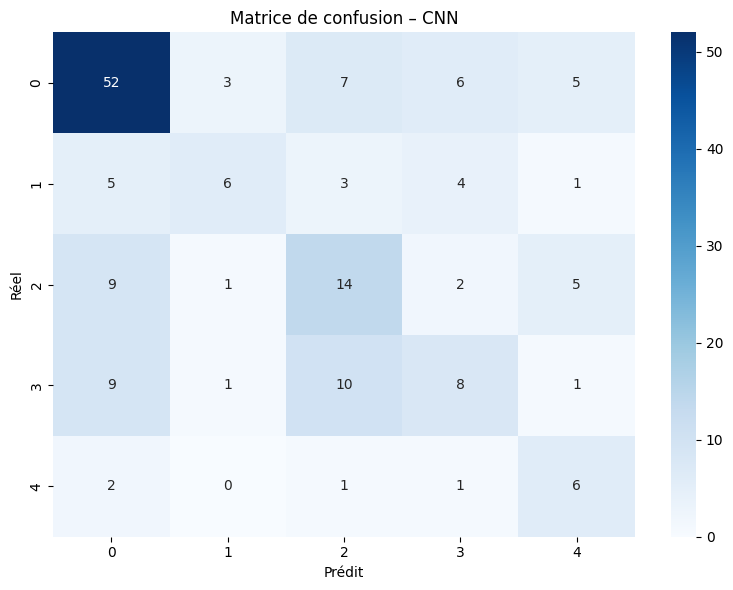

In [ ]:
final_metrics = evaluate(model, val_loader, criterion, DEVICE)
y_true, y_pred = final_metrics["y_true"], final_metrics["y_pred"]

print(f"Loss: {final_metrics['loss']:.4f}")
print(f"Accuracy: {final_metrics['acc']:.4f}")
print(f"Macro Recall: {final_metrics['recall_macro']:.4f}")
print(f"Macro F1: {final_metrics['f1_macro']:.4f}")


cm = final_metrics["confusion_matrix"]

print(classification_report(y_true, y_pred, digits=4))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion – CNN')
plt.tight_layout()
plt.show()


In [ ]:
# Chargement des données de test depuis le fichier pickle
with open(TEST_PATH, "rb") as f:
    test_data = pickle.load(f)

# Extraction des images de test 
test_images = test_data["images"].astype(np.uint8)

# Création du dataset de test
test_dataset = RetinaDataset(
    test_images,
    transform=val_transform
)

# DataLoader pour l'inférence sur l'ensemble de test
test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False
)

# Initialisation du modèle CNN et chargement des poids entraînés
model = CNN(num_classes=5)
model.load_state_dict(
    torch.load(MODEL_PATH, map_location=DEVICE)
)

model.to(DEVICE)
model.eval()

# Liste pour stocker toutes les prédictions
all_preds = []

with torch.no_grad():
    for imgs in test_loader:
        imgs = imgs.to(DEVICE)

        # Propagation avant
        outputs = model(imgs)

        # Prédiction des classes
        preds = outputs.argmax(dim=1)

        # Stockage des prédictions
        all_preds.extend(preds.cpu().numpy())

# Conversion des prédictions en tableau NumPy
all_preds = np.array(all_preds)

# Création du DataFrame pour la soumission Kaggle
df = pd.DataFrame({
    "ID": np.arange(1, len(all_preds) + 1),
    "Label": all_preds
})

# Sauvegarde du fichier CSV de soumission
df.to_csv("IFT3395_YAPS_MCS_V61.csv", index=False)


Afin de gérer la variance entre entraînement, on peut runner l'entraînement plusieurs fois avec des seeds différents (exemple, 0, 1, 17, 21, 42). La section ci-dessous pourra être décommenter si l'on souhait utiliser cette stratégie. Il sera nécessairement au préalable de run l'entraînement le nombre de fois voulu et en eregistrant un checkpoint pour chaque run.

In [284]:
# On récupère les checkpoints pour chaque run différents.
"""
MODEL_PATHS = [
    "best_model_1.pth","best_model_2.pth","best_model_3.pth","best_model_4.pth","best_model_5.pth",

]
"""

'\nMODEL_PATHS = [\n    "best_model_1.pth","best_model_2.pth","best_model_3.pth","best_model_4.pth","best_model_5.pth",\n\n]\n'

In [285]:
"""
with open(TEST_PATH, "rb") as f:
    test_data = pickle.load(f)
X_test = test_data["images"] if isinstance(test_data, dict) else test_data
test_loader = DataLoader(RetinaDataset(X_test, transform=val_transform), batch_size=BATCH_SIZE, shuffle=False)
"""

'\nwith open(TEST_PATH, "rb") as f:\n    test_data = pickle.load(f)\nX_test = test_data["images"] if isinstance(test_data, dict) else test_data\ntest_loader = DataLoader(RetinaDataset(X_test, transform=val_transform), batch_size=BATCH_SIZE, shuffle=False)\n'

In [ ]:
"""

models = []
for path in MODEL_PATHS:
    try:
        m = CNN(num_classes=5).to(DEVICE)
        m.load_state_dict(torch.load(path, map_location=DEVICE))
        m.eval()
        models.append(m)
        print(f"Chargé : {path}")
    except Exception as e:
        print(f"Erreur sur {path}: {e}")

"""


'\n\nmodels = []\nfor path in MODEL_PATHS:\n    try:\n        m = CNN(num_classes=5).to(DEVICE)\n        m.load_state_dict(torch.load(path, map_location=DEVICE))\n        m.eval()\n        models.append(m)\n        print(f"✓ Chargé : {path}")\n    except Exception as e:\n        print(f"Erreur sur {path}: {e}")\n\n'

In [ ]:
"""

final_preds = []

with torch.no_grad():
    for imgs in test_loader:
        imgs = imgs.to(DEVICE)

        batch_probs_sum = torch.zeros(imgs.size(0), 5).to(DEVICE)

        for model in models:
            logits = model(imgs)
            probs = F.softmax(logits, dim=1)
            batch_probs_sum += probs

        avg_probs = batch_probs_sum / len(models)

        preds = torch.argmax(avg_probs, dim=1)
        final_preds.extend(preds.cpu().numpy())
"""


'\n\nfinal_preds = []\n\nprint("Démarrage de l\'ensemble...")\nwith torch.no_grad():\n    for imgs in test_loader:\n        imgs = imgs.to(DEVICE)\n\n        # On va stocker la somme des probabilités pour ce batch\n        # Forme : [Batch_Size, 5 Classes]\n        batch_probs_sum = torch.zeros(imgs.size(0), 5).to(DEVICE)\n\n        for model in models:\n            logits = model(imgs)\n            # IMPORTANT : On transforme les logits en probabilités (0.0 à 1.0)\n            probs = F.softmax(logits, dim=1)\n            batch_probs_sum += probs\n\n        # On fait la moyenne (diviser par 5)\n        avg_probs = batch_probs_sum / len(models)\n\n        # On prend la classe qui a la plus haute probabilité moyenne\n        preds = torch.argmax(avg_probs, dim=1)\n        final_preds.extend(preds.cpu().numpy())\n'

In [ ]:
"""

df = pd.DataFrame({"ID": np.arange(1, len(final_preds) + 1), "Label": final_preds})
df.to_csv("IFT3365_YAPS_MCS_V62.csv", index=False)


"""

'\n\ndf = pd.DataFrame({"ID": np.arange(1, len(final_preds) + 1), "Label": final_preds})\ndf.to_csv("IFT3365_YAPS_MCS_V62.csv", index=False)\nprint("Fichier \'submission_ensemble_5seeds.csv\' généré avec succès.")\n\n'